In [49]:
import os
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Hyperparameter Optimization

Hyperparemter optimization is often one of the final steps in a data science project.  Once you have a shortlist of promising models you will want to fine-tune them so that they perform better on your particular dataset.  

In this notebook we will go over three techniques used to find optimal hyperparameters with examples on how to implement them on models in Scikit-Learn and then finally neural networks in Keras. The three techniques we will discuss are as follows:

* Grid Search
* Randomized Search
* Bayesian Optimization

Let's start by loading the MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set.

In [21]:
import tensorflow as tf
from tensorflow import keras

In [94]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The dataset contains 60,000 grayscale images, each 28x28 pixels:

In [28]:
X_train.shape

(60000, 28, 28)

In [33]:
X_test.shape

(10000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [29]:
X_train.dtype

dtype('uint8')

To give you a feel for the complexity of the classification task, the figure below shows a few images from the MNIST dataset:

Saving figure mnist_plot


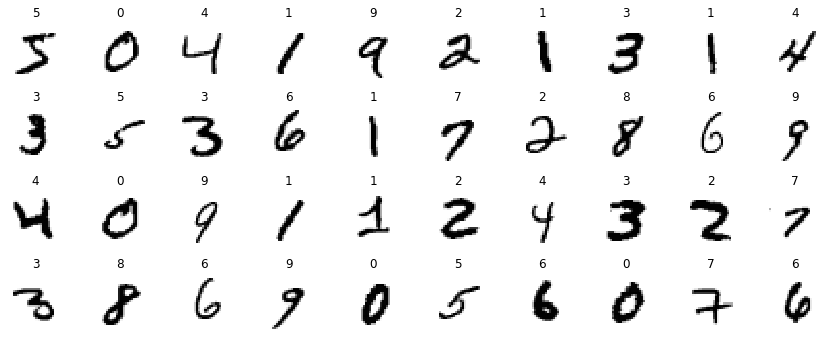

In [30]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("mnist_plot")
plt.show()

Reshape the dataset into a 2-dimensional array: 60,000 for the number of instances and 784 because 28 x 28 = 784:

In [95]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Grid Search

One option would be to fiddle around with the hyperparameters manually, until you find a great combination of hyperparameter values that optimize your performance metric.  This would be very tedious work, and you may not have time to explore many combinations. 

Instead, you should get Scikit-Learn's ```GridSearchCV``` to do it for you. All you have to do is tell it which hyperparameters you want to experiment with and what values to try out, and it will use cross-validation to evauluate all the possible combinations of hyperparameter values.  

Let's work through an example where we use ```GridSearchCV``` to search for the best combination of hyperparameter values for a RandomForestClassifier.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'bootstrap': [True],
     'max_depth': [6, 10],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]}
     ]

forest_clf = RandomForestClassifier()

forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 43.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

The `param_grid` tells Scikit-Learn to evauluate 1 x 2 x 2 x 2 x 2 x 2 combinations of `bootstrap`, `max_depth`, `max_features`, `min_samples_leaf`, `min_samples_split` and `n_estimators` hyperparameter values specified. The grid search will explore 32 combinations of RandomForestClassifier hyperparemeter values, and it will train each model 5 times (since we are using five-fold cross-validation). In other words, all in all, there will be 32 x 5 = 160 rounds of training! It may take a long time, but when it is done you can get the best combination of hyperparameters like this:

In [41]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 350}

Since n_estimators=350 and max_depth=10 are the maximum values that were evaluated, you should probably try searching again with higher values; the score may continue to improve.

You can also get the best estimator directly:

In [42]:
forest_grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

And of course the evaluation score is also available:

In [58]:
forest_grid_search.best_score_

0.9459

Our best score here is 0.9459 accuracy which is not bad for such a small paramater grid specified.

# Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
* If you let randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach). 
* Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

Let's walk through the same example as before but instead use `RandomizedSearchCV`.  Since we are using `RandomizedSearchCV` we can search a larger param space than we did with `GridSearchCV`:

In [53]:
from sklearn.model_selection import RandomizedSearchCV

param_space = {"bootstrap": [True],
        "max_depth": [6, 8, 10, 12, 14],
        "max_features": ['auto', 'sqrt','log2'],
        "min_samples_leaf": [2, 3, 4],
        "min_samples_split": [2, 3, 4, 5],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

forest_rand_search = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
                                        scoring="accuracy", verbose=True, cv=5,
                                        n_jobs=-1, random_state=42)

forest_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 81.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Same as above we can see the best hyperparameters that were explored:

In [54]:
forest_rand_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 14,
 'bootstrap': True}

Also the best estimator:

In [55]:
forest_rand_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

And check the best score:

In [57]:
forest_rand_search.best_score_

0.9620666666666666

Our best performance was 0.9621 accuracy beating `GridSearchCV` by 1.5%.  As you can see since `RandomizedSearchCV` allows us to explore a larger hyperparameter space in relatively the same amount of time and generally outputs better results than `GridSearchCV`.  

You can now save this model, evaluate it on the test set, and, if you are satisfied with its performance, deploy it to production. Using randomized search is not too hard, and it works well for many fairly simple problems. When training is slow, however, (e.g., for more complex problems with larger datasets), this approach will only explore a tiny portion of the hyperparameter space. You can partially alleviate this problem by assisting the search process manually: first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on. This approach will hopefully zoom in on a good set of hyperparameters. However, it's very time consuming, and probably not the best use of your time.

# Bayesian Optimization

Fortunately, there are many techniques to explore a search space much more efficiently than randomly. Their core idea is simple: when a region of the space turns out to be good, it should be explored more. Such techniques take care of the "zooming" process for you and lead to much better solutions in much less time. 

One such technique is called Bayesian Optimization and we will use Scikit-Optimize (Skopt) [https://scikit-optimize.github.io/](https://scikit-optimize.github.io) to perform Bayesian Optimization.  Skopt is a general-purpose optimization library that performs Bayesian Optimization with its class `BayesSearchCV` using an interface similar to `GridSearchCV`.  

If you don't have Skopt already installed go ahead and run the following line of code in your virtual environment:

In [61]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.4MB/s eta 0:00:011


There are only 2 main differences when performing Bayesian Optimization using Skopt's `BayesSearchCV`.  First, when creating your search space you need to make each hyperparameters space a probability distribution as opposed to using lists for `GridSearchCV`. Skopt makes this easy for you by importing Real, Categorical, and Integer from skopt.space.

* **Real**: Continuous hyperparameter space.
* **Integer**: Discrete hyperparameter space.
* **Categorical**: Categorical hyperparameter space.

Below you can see examples of using both the categorical and integer functions. For categorical spaces simply imput a list inside the function. For Integer spaces input the minimum and maximum values you want `BayesSearchCV` to explore.

In [64]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(100, 500)
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.9336833333333333
best score: 0.9495833333333333
best score: 0.9495833333333333
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333


//anaconda3/envs/metis/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score: 0.97
best score: 0.97
best score: 0.97
best score: 0.97
best score: 0.97


BayesSearchCV(cv=5, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators='warn', n_jobs=None,
                                               oob_score=False,
                                               random_...
                             'max_depth': Integer(lo

Just like in Scikit-Learn we can view the best parameters:

In [65]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 20),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 2),
             ('n_estimators', 500)])

And the best estimator:

In [66]:
forest_bayes_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

And the best score:

In [67]:
forest_bayes_search.best_score_

0.97

Bayesian Optimization allowed us to improve our accuracy by another whole percent in the same amount of iterations as Randomized Search.  I hope this convinces you to stray away from your comfort zone using `GridSearchCV` and `RandomizedSearchCV` to try implementing something new like `BayesSearchCV` in your next project.  Hyperparameter searching can be tedious, but there are tools that can do the tedious work for you.

# Fine-Tuning Neural Network Hyperparameters

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more. It can be hard to know what combination of hyperparameters is the best for your task.

One option is to simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation). For example, we can use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space.  To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn classifiers. The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [68]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Since we are going to train the neural network using gradient descent, we must scale the input features. For simplicity, we'll scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (this also converts them to floats):

In [69]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [84]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

This function creates a simple Sequential model for multiclass classification with the given input shape and the given number of hidden layers and neurons, and it compiles it using an SGD optimizer configured with the specified learning rate.  

Next, let's create a KerasClassifier based on this `build_model()` function:

In [85]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

The `KerasClassifier` object is a thin wrapper around the Keras model built using `build_model()`. This will allow us to use this object like a regular Scikit-Learn classifier: we can train it using its `fit()` method, then evaluate it using its `score()` method, and use it to make predictions using its `predict()` method.

We don't want to train and evaluate a single model like this though, we want to train hundreds of variants and see which one performs best on the validation set. Since there are many hyperparamters, it is preferable to use randomized search rather than grid search. Let's try to explore the number of hidden layers, the number of neurons, and the learning rate:

In [86]:
from scipy.stats import reciprocal

keras_param_space = {"n_hidden": [1, 2, 3, 4],
                      "n_neurons": np.arange(30, 300),
                      "learning_rate": reciprocal(3e-4, 3e-2) 
}

keras_rand_search = RandomizedSearchCV(keras_clf, keras_param_space, n_iter=20, 
                                   cv=5, scoring="accuracy", n_jobs=-1, verbose=True)

keras_rand_search.fit(X_train, y_train, epochs=100,
                       validation_data=(X_valid, y_valid),
                       callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 135.5min finished


Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5520 - accuracy: 0.8586 - val_loss: 0.3218 - val_accuracy: 0.9122
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2984 - accuracy: 0.9168 - val_loss: 0.2512 - val_accuracy: 0.9318
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2488 - accuracy: 0.9312 - val_loss: 0.2181 - val_accuracy: 0.9422
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2168 - accuracy: 0.9406 - val_loss: 0.1955 - val_accuracy: 0.9484
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1930 - accuracy: 0.9463 - val_loss: 0.1753 - val_accuracy: 0.9548
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1744 - accuracy: 0.9521 - val_loss: 0.1608 - val_accuracy: 0.9590
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1591 - accuracy: 0.9558 - val_loss: 0.1497 - val_ac

1719/1719 [==============================] - 2s 1ms/step - loss: 0.0219 - accuracy: 0.9962 - val_loss: 0.0653 - val_accuracy: 0.9804
Epoch 58/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0213 - accuracy: 0.9965 - val_loss: 0.0647 - val_accuracy: 0.9806
Epoch 59/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0208 - accuracy: 0.9965 - val_loss: 0.0644 - val_accuracy: 0.9792
Epoch 60/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0203 - accuracy: 0.9966 - val_loss: 0.0646 - val_accuracy: 0.9806
Epoch 61/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0197 - accuracy: 0.9970 - val_loss: 0.0634 - val_accuracy: 0.9800
Epoch 62/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0192 - accuracy: 0.9971 - val_loss: 0.0641 - val_accuracy: 0.9812
Epoch 63/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0188 - accuracy: 0.9972 - val_loss: 0.0636 - val_accuracy

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a0fb0908>,
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a0d0b9b0>,
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  3...
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, sc

In [87]:
keras_rand_search.best_params_

{'learning_rate': 0.015529337745078654, 'n_hidden': 1, 'n_neurons': 237}

In [88]:
keras_rand_search.best_estimator_

In [90]:
keras_rand_search.best_score_

0.9752909090909091

Our accuracy increased by another .5%!

# Conclusions

Finally, we will evaluate each on the withled test set to see how well our models generalize to unseen data:

In [99]:
forest_grid_search.score(X_test, y_test)

0.9486

In [100]:
forest_rand_search.score(X_test, y_test)

0.9662

In [101]:
forest_bayes_search.score(X_test, y_test)

0.9721

In [102]:
keras_rand_search.score(X_test, y_test)

0.9773

## Summary 

Hyperparameter tuning is still an active area of research, and different algorithms are being produced today.  But having basic algorithms in your back pocket can alleviate a lot of the tedious work searching for the best hyperparameters.  Remember, randomized search is almost always preferable than grid search unless you have very few hyperparameters to explore.  If you have a more complex problem using a larger dataset you might want to turn to a technique that explores a search space much more efficiently like Bayesian Optimization.  Quick recap of what we went over:

* Implementing GridSearchCV in Scikit-Learn.
* Implementing RandomizedSearchCV in Scikit-Learn.
* Implementing BayesSearchCV in Scikit-Optimize.
* Using Keras Wrappers to implement RandomizedSearchCV on Neural Networks.